In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
from duneanalytics import DuneAnalytics

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
csv_dir = os.path.join(output_dir, 'csv')
os.makedirs(png_dir, exist_ok=True)
os.makedirs(csv_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py
%run {helper_dir}/mk_design_matrix.py
%run {helper_dir}/fit_data.py

In [4]:
# get Dune Analytics login credentials
MY_USERNAME = os.environ.get('DUNE_USERNAME')
MY_PASSWORD = os.environ.get('DUNE_PASSWORD')
dune = DuneAnalytics(MY_USERNAME, MY_PASSWORD)

## Input

In [5]:
chain = 'Avalanche'

In [6]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('AUM & Glp Supply'):
        fnames['AUM & Glp Supply'] = fname
    if fname.startswith('Glp Price Comparison'):
        fnames['Glp Price Comparison'] = fname
    if fname.startswith('Open Interest'):
        fnames['Open Interest'] = fname
fnames

{'AUM & Glp Supply': 'AUM & Glp Supply_2021-12-22_2022-09-07.csv',
 'Glp Price Comparison': 'Glp Price Comparison_2021-08-31_2022-09-07.csv',
 'Open Interest': 'Open Interest_2021-12-22_2022-09-07.csv'}

In [7]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
save_csv_dir = os.path.join(csv_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)
os.makedirs(save_csv_dir, exist_ok=True)

## Prep Data

In [8]:
# In the 'AUM & Glp Supply' file, col `aum` is in $, and `glpSupply` in quantity/count; 
# each row is the total stock measured at the end of the day. 
#
# I checked that `aum` == `glpSupply` * `glpPrice`, where `glpPrice` is from the 'Glp Price Comparison' file.
# So this `aum` is only a GLP `aum`, and it doesn't include staked GMX. So it doesn't capture the full picture. 
# Let's ignore it.
glp_supply = pd.read_csv(os.path.join(data_dir, chain, fnames['AUM & Glp Supply']), 
                         parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpSupply'])
glp_supply.tail()

,glpSupply
Date,
2022-09-03,"96,454,331.1028"
2022-09-04,"96,292,852.8446"
2022-09-05,"95,996,850.4261"
2022-09-06,"94,787,332.4379"
2022-09-07,"94,812,462.2857"


In [9]:
glp_price = pd.read_csv(os.path.join(data_dir, chain, fnames['Glp Price Comparison']), 
                        parse_dates=['Date'], index_col='Date', usecols=['Date', 'glpPrice'])
glp_price.tail()

,glpPrice
Date,
2022-09-03,0.7734
2022-09-04,0.7765
2022-09-05,0.7773
2022-09-06,0.7667
2022-09-07,0.7788


In [10]:
df = glp_supply.join(glp_price).rename(columns={'glpSupply': 'glp_supply', 'glpPrice': 'glp_price'})

# calculate daily GLP value and net dollar flow 
df = df.assign(glp_value = lambda x: x.glp_supply * x.glp_price,
               glp_ndf = lambda x: x.glp_value - x.glp_value.shift(1)
              )
df.tail()

,glp_supply,glp_price,glp_value,glp_ndf
Date,,,,
2022-09-03,"96,454,331.1028",0.7734,"74,596,710.4061","-470,139.8300"
2022-09-04,"96,292,852.8446",0.7765,"74,772,103.8369","175,393.4308"
2022-09-05,"95,996,850.4261",0.7773,"74,614,874.5350","-157,229.3019"
2022-09-06,"94,787,332.4379",0.7667,"72,677,376.0888","-1,937,498.4462"
2022-09-07,"94,812,462.2857",0.7788,"73,842,258.5935","1,164,882.5047"


In [11]:
# read open interest data, which are already in usd
oi = pd.read_csv(os.path.join(data_dir, chain, fnames['Open Interest']), parse_dates=['Date'], index_col='Date')
oi.columns = oi.columns.str.lower()

# calc total open interest by adding the shorts and longs
oi = oi.assign(oi = lambda x: x.short + x.long)
oi.tail()

,short,long,oi
Date,,,
2022-09-03,"8,356,049.1364","8,187,836.1658","16,543,885.3022"
2022-09-04,"9,212,602.6262","8,035,976.1093","17,248,578.7356"
2022-09-05,"9,326,688.4643","6,452,993.1629","15,779,681.6272"
2022-09-06,"8,372,267.0385","6,700,849.0688","15,073,116.1074"
2022-09-07,"11,152,086.0983","5,644,670.5545","16,796,756.6528"


In [12]:
df = df.join(oi)

if chain == 'Avalanche':
    df = df.loc['2022-01-07':, :] # all days before have tiny numbers, probably before official launch or people don't know

df = df.iloc[:-1, :] # drop the last row because the most recent date may not be a full day
df = df.dropna()

# calculate ratios
df = df.assign(oi_to_glp_ratio = lambda x: x.oi / x.glp_value,
               short_to_long_ratio = lambda x: x.short / x.long)
df.head()

,glp_supply,glp_price,glp_value,glp_ndf,short,long,oi,oi_to_glp_ratio,short_to_long_ratio
Date,,,,,,,,,
2022-01-07,"13,861,423.3623",1.1558,"16,020,423.6473","3,030,483.9502","317,145.7089","2,066,615.6515","2,383,761.3603",0.1488,0.1535
2022-01-08,"17,158,471.3889",1.1452,"19,649,131.7490","3,628,708.1016","3,512,067.6135","2,647,320.6079","6,159,388.2213",0.3135,1.3266
2022-01-09,"18,813,523.3498",1.1532,"21,696,509.6542","2,047,377.9052","6,543,907.9788","1,915,059.8339","8,458,967.8127",0.3899,3.4171
2022-01-10,"19,716,308.4581",1.1072,"21,829,351.4954","132,841.8412","5,504,437.5404","4,143,706.3117","9,648,143.8521",0.4420,1.3284
2022-01-11,"25,897,343.3725",1.1369,"29,442,958.6867","7,613,607.1914","1,298,455.8492","5,993,064.4934","7,291,520.3426",0.2476,0.2167


In [13]:
# get btc, eth and avax prices from dune

def extract_frame_from_dune_data(dune_data):    
    dd = dune_data['data']['get_result_by_result_id']
    df = pd.json_normalize(dd, record_prefix='')
    df = df.loc[:, df.columns.str.startswith('data')]
    df.columns = df.columns.str.replace('data.', '', regex=False)
    # set `day` as index
    df['date'] = pd.to_datetime(df.day.str.replace('T.*', '', regex=True))
    del df['day']
    df = df.set_index('date')
    # drop the last row cuz it may not always be a full day
    return df.iloc[:-1, :]

dune.login()
dune.fetch_auth_token()

token_prices = dune.query_result(dune.query_result_id(query_id=1003888))
df_prices = extract_frame_from_dune_data(token_prices)

In [14]:
df = df.join(df_prices.loc[:, df_prices.columns.str.endswith('median')])
df.head()

,glp_supply,glp_price,glp_value,glp_ndf,short,long,oi,oi_to_glp_ratio,short_to_long_ratio,avax_price_median,btc_price_median,eth_price_median
Date,,,,,,,,,,,,
2022-01-07,"13,861,423.3623",1.1558,"16,020,423.6473","3,030,483.9502","317,145.7089","2,066,615.6515","2,383,761.3603",0.1488,0.1535,88.9700,"41,922.9200","3,216.0800"
2022-01-08,"17,158,471.3889",1.1452,"19,649,131.7490","3,628,708.1016","3,512,067.6135","2,647,320.6079","6,159,388.2213",0.3135,1.3266,86.9000,"41,908.1150","3,209.3000"
2022-01-09,"18,813,523.3498",1.1532,"21,696,509.6542","2,047,377.9052","6,543,907.9788","1,915,059.8339","8,458,967.8127",0.3899,3.4171,85.4400,"41,614.6500","3,109.2200"
2022-01-10,"19,716,308.4581",1.1072,"21,829,351.4954","132,841.8412","5,504,437.5404","4,143,706.3117","9,648,143.8521",0.4420,1.3284,87.0000,"41,789.7600","3,110.3600"
2022-01-11,"25,897,343.3725",1.1369,"29,442,958.6867","7,613,607.1914","1,298,455.8492","5,993,064.4934","7,291,520.3426",0.2476,0.2167,86.3300,"42,181.6700","3,124.5800"


## Daily Open Interest

Open interest is a measure of trader activity. Little or no open interest means traders aren't using the platform. High open interest means there are many open positions, which implies more platform revenue but at the same time can put pressure on the GLP pool.

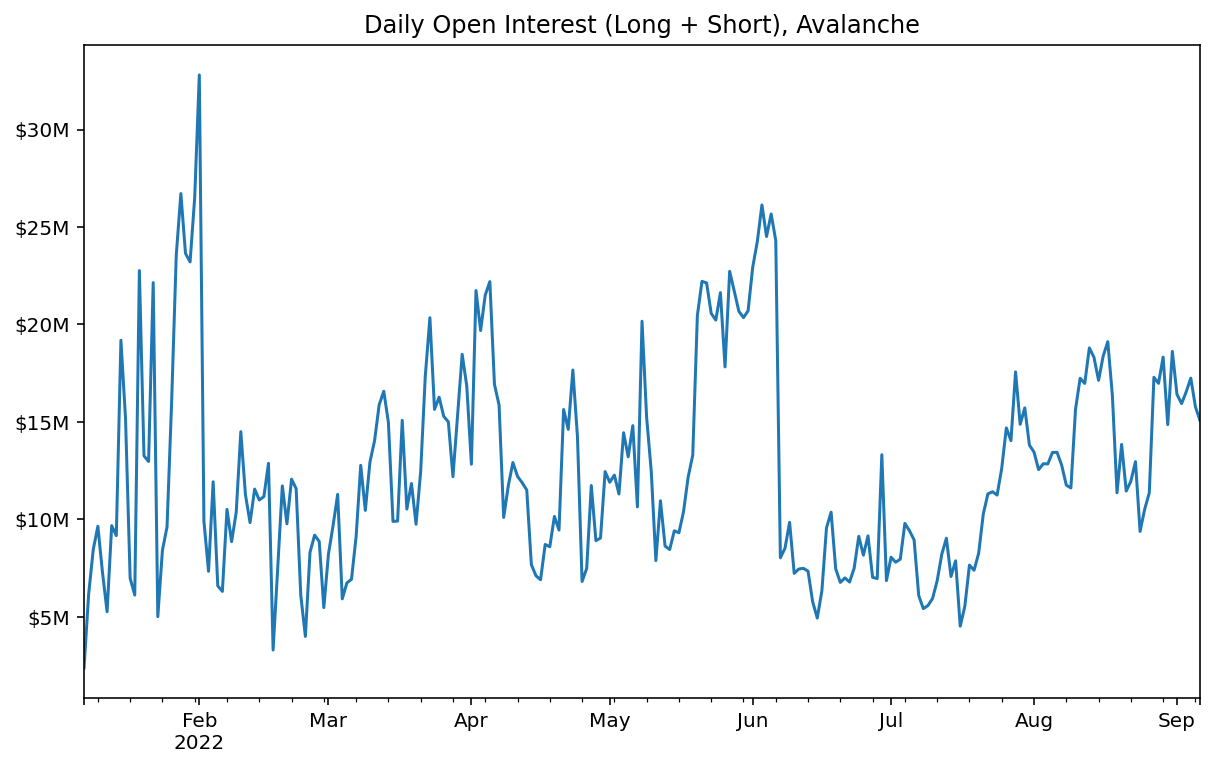

In [15]:
# plot daily open interest
ax = df.oi.plot(title="Daily Open Interest (Long + Short), {}".format(chain), ylabel='', xlabel='', rot=0)
formatter = FuncFormatter(human_format_dollar_or_num(dollar=True, decimals=0))
ax.yaxis.set_major_formatter(formatter)
plt.savefig(os.path.join(save_fig_dir, 'daily_open_interest.png'), dpi=300);

The above figure may be misleading because open interest is measured in dollars, which is influenced by token prices. Let's remove the price effect and we'll simply divide open interest by btc price. The result is a proxy to the number of open positions.

intercept: 211.58217725505492 slope: 1.6850777142163587


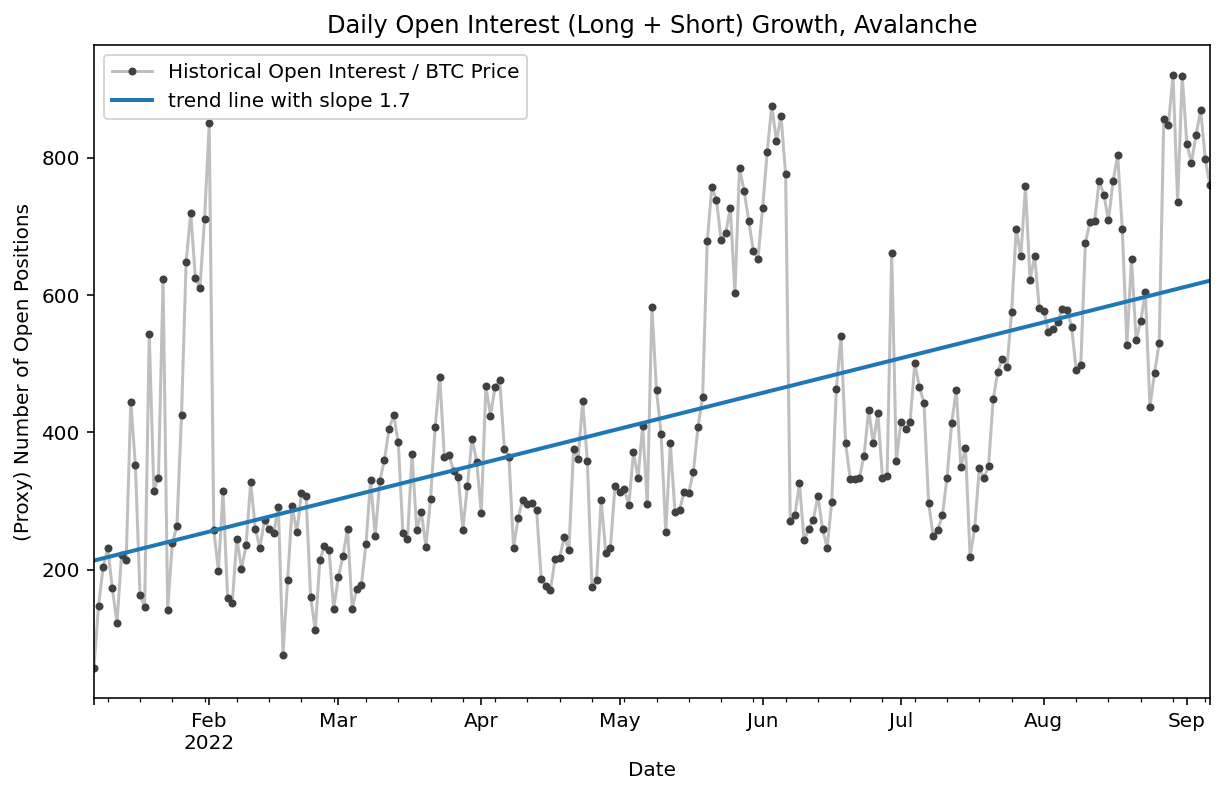

In [16]:
oi_proxy = df.oi / df.btc_price_median
X = mk_X_linear_trend(oi_proxy.index) # make linear trend features

dd = fit_linreg(X, oi_proxy) # fit linear trend line, returns a dictionary
yhat = dd['yhat']
slope = dd['slope']

ax = plot_timeseries_with_trendline(
    oi_proxy, yhat, title='Daily Open Interest (Long + Short) Growth, {}'.format(chain),
    ylabel='(Proxy) Number of Open Positions', 
    ytru_legend='Historical Open Interest / BTC Price', 
    yhat_legend="trend line with slope {:,.1f}".format(slope))

plt.savefig(os.path.join(save_fig_dir, 'daily_open_interest_div_by_btc_price.png'), dpi=300);

We see trading activities definitely have been increasing. 

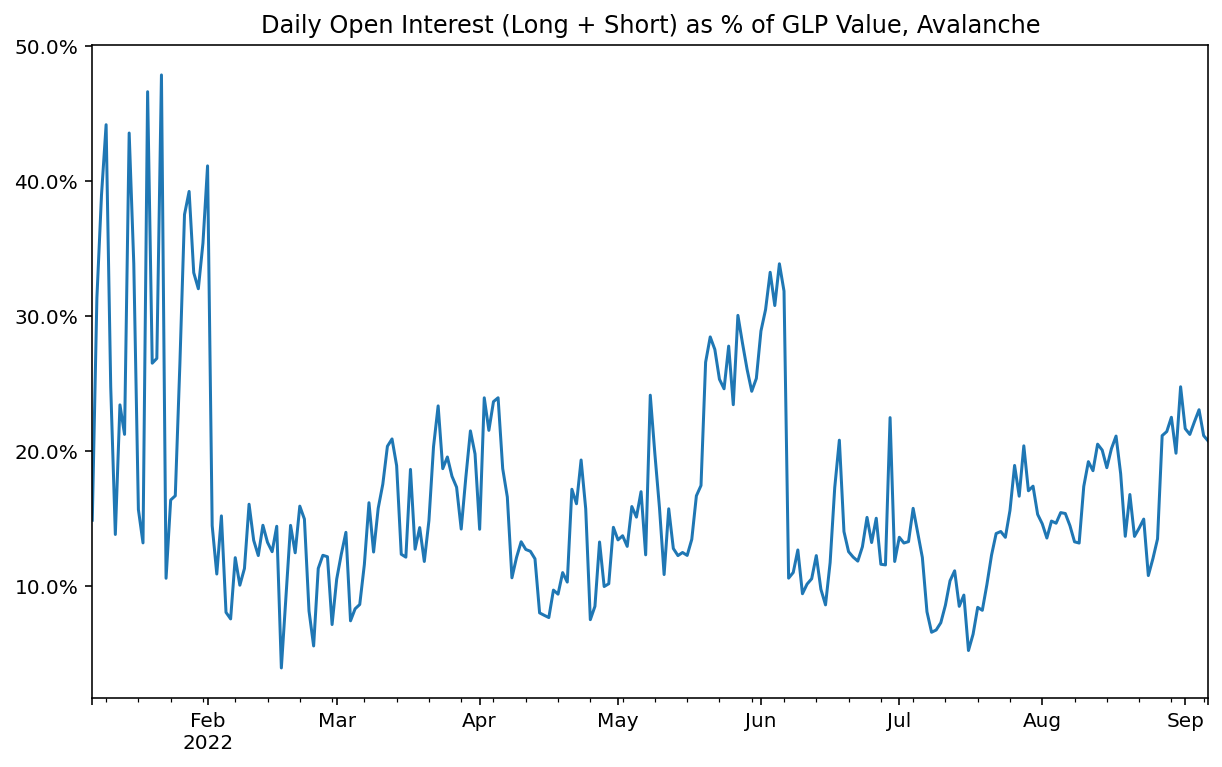

In [17]:
# plot daily open interest as a % of GLP value
oi_to_glp_ratio = df.oi_to_glp_ratio * 100
ax = oi_to_glp_ratio.plot(title="Daily Open Interest (Long + Short) as % of GLP Value, {}".format(chain),
                          ylabel='', xlabel='', rot=0)
ax.yaxis.set_major_formatter(PercentFormatter())
plt.savefig(os.path.join(save_fig_dir, 'daily_open_interest_to_glp_ratio.png'), dpi=300);

Even if this % reaches 100%, it's still ok because the longs and shorts are also against each other as all collaterals and GLP assets are placed into the same vault. Refer to this [technical doc](https://gmx-io.notion.site/gmx-io/GMX-Technical-Overview-47fc5ed832e243afb9e97e8a4a036353). 

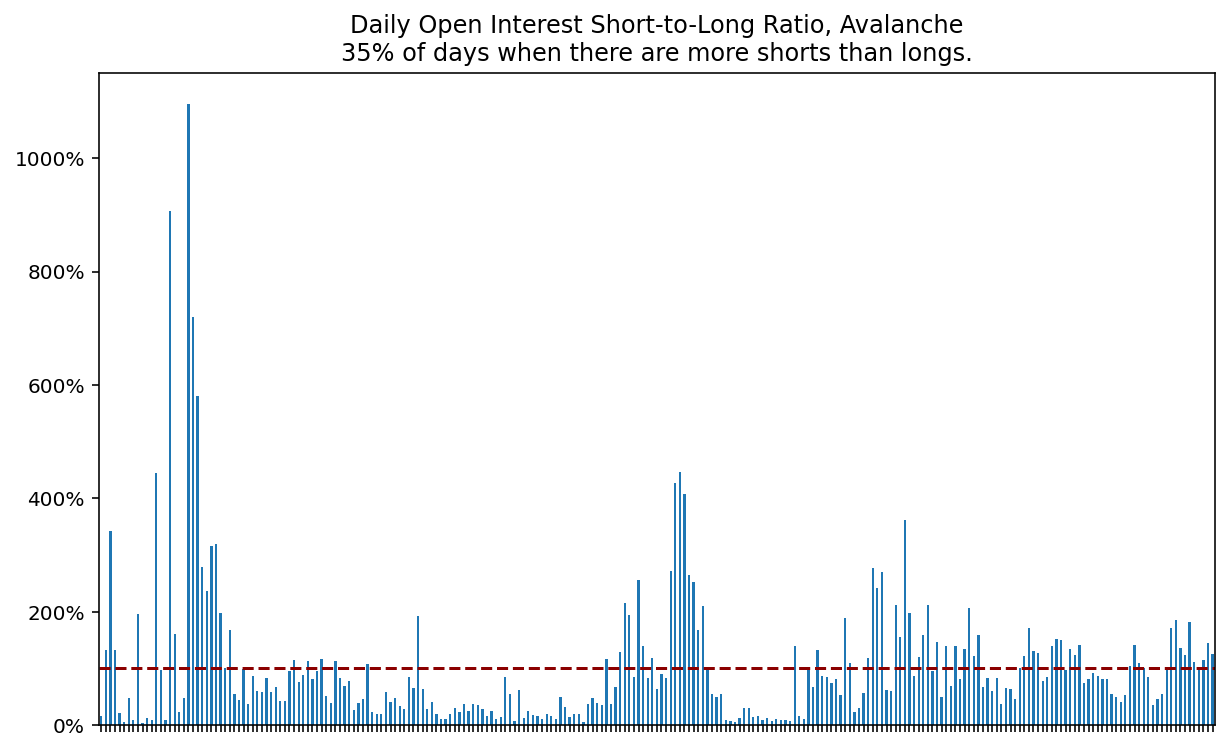

In [18]:
# plot daily short-to-long ratio
short_to_long_ratio = df.short_to_long_ratio * 100
tit = "Daily Open Interest Short-to-Long Ratio, {}".format(chain)
subtit = "{:.0f}% of days when there are more shorts than longs.".format(np.round(np.mean(df.short_to_long_ratio >= 1)*100))
ax = short_to_long_ratio.plot(kind='bar', title=tit+'\n'+subtit, ylabel='', xlabel='', rot=0)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set(xticklabels=[])
ax.set(xlabel=None)
plt.axhline(y=100, color='darkred', linestyle='--')
plt.savefig(os.path.join(save_fig_dir, 'daily_open_interest_short_to_long_ratio.png'), dpi=300);